# Analyse Exploratoire des Données de Fréquentation des Gares SNCF

## Objectifs
1. Comprendre la structure et la qualité des données
2. Nettoyer et préparer les données pour l'analyse
3. Identifier les tendances principales
4. Préparer les données pour le clustering

## Table des matières
1. [Configuration initiale](#1)
2. [Chargement et aperçu des données](#2)
3. [Nettoyage des données](#3)
4. [Analyse univariée](#4)
5. [Analyse temporelle](#5)
6. [Préparation pour le clustering](#6)
7. [Export des données nettoyées](#7)

<a id='1'></a>
## 1. Configuration initiale

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration des visualisations
%matplotlib inline
def set_style():
    sns.set_style('darkgrid')
    sns.set_palette('husl')


# Chemins des fichiers
RAW_DATA_PATH = Path('../data/raw/frequentation-gares.csv')
PROCESSED_DATA_PATH = Path('../data/processed/frequentation-gares-clean.csv')

<a id='2'></a>
## 2. Chargement et aperçu des données

In [66]:
# Charger les données
df = pd.read_csv(RAW_DATA_PATH, sep=';')

print("Shape des données :", df.shape)
print("\nPremières lignes :")
df.head()

print("\nInformations sur les colonnes :")
df.info()

Shape des données : (3010, 22)

Premières lignes :

Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Nom de la gare                        3010 non-null   object
 1   Code UIC                              3010 non-null   int64 
 2   Code postal                           3010 non-null   int64 
 3   Segmentation DRG                      2943 non-null   object
 4   Total Voyageurs 2023                  3010 non-null   int64 
 5   Total Voyageurs + Non voyageurs 2023  3010 non-null   int64 
 6   Total Voyageurs 2022                  3010 non-null   int64 
 7   Total Voyageurs + Non voyageurs 2022  3010 non-null   int64 
 8   Total Voyageurs 2021                  3010 non-null   int64 
 9   Total Voyageurs + Non voyageurs 2021  3010 non-null   int64 
 10  Total Voyage

<a id='3'></a>
## 3. Nettoyage des données

In [67]:
def clean_data(df):
    # Copie du DataFrame
    df_clean = df.copy()
    
    # Renommage des colonnes
    df_clean.columns = df_clean.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # Nettoyage des valeurs manquantes
    cols_trafic = [col for col in df_clean.columns if 'total_voyageurs_20' in col]
    df_clean[cols_trafic] = df_clean[cols_trafic].fillna(0)
    
    # Suppression des gares sans trafic
    df_clean['total_trafic'] = df_clean[cols_trafic].sum(axis=1)
    df_clean = df_clean[df_clean['total_trafic'] > 0]
    df_clean.drop('total_trafic', axis=1, inplace=True)
    
    # Standardisation des codes postaux
    df_clean['code_postal'] = df_clean['code_postal'].astype(str).str.zfill(5)
    
    return df_clean

df_clean = clean_data(df)
print("Shape après nettoyage :", df_clean.shape)

Shape après nettoyage : (2998, 22)


<a id='4'></a>
## 4. Analyse univariée

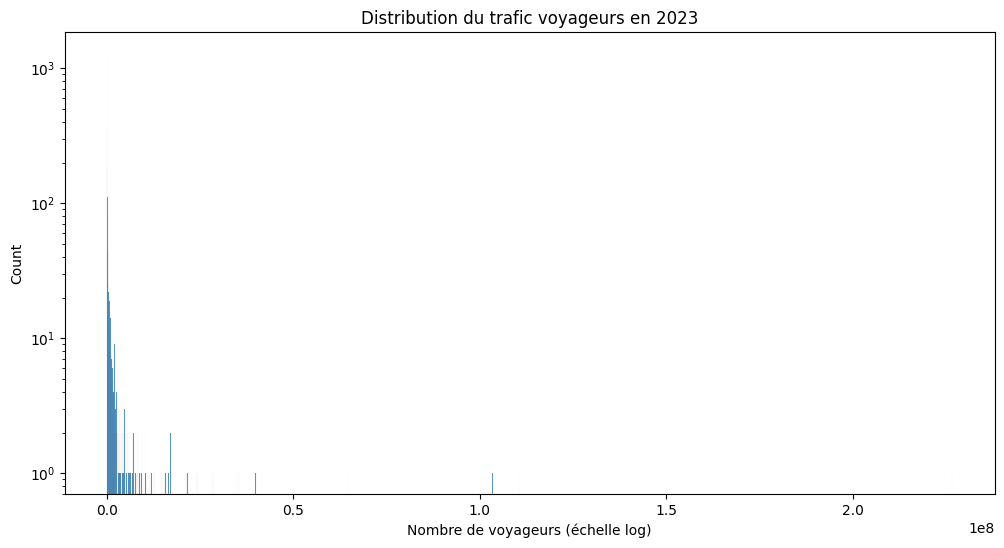


Top 10 des gares les plus fréquentées en 2023 :
              nom_de_la_gare  total_voyageurs_2023
1009      Paris Gare du Nord             226768485
2460      Paris Gare de Lyon             110498896
1011      Paris Saint-Lazare             103453620
1010      Paris Montparnasse              64471254
932           Lyon Part Dieu              40088689
2458               Paris Est              39877017
834          Juvisy-sur-Orge              35396457
2318                 Magenta              35160793
2065  Haussmann Saint-Lazare              34704501
562         Aulnay-sous-Bois              28732540


In [68]:
# Distribution du trafic 2023
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='total_voyageurs_2023', log=True)
plt.title('Distribution du trafic voyageurs en 2023')
plt.xlabel('Nombre de voyageurs (échelle log)')
plt.show()

# Top 10 des gares
top_10 = df_clean.nlargest(10, 'total_voyageurs_2023')[['nom_de_la_gare', 'total_voyageurs_2023']]
print("\nTop 10 des gares les plus fréquentées en 2023 :")
print(top_10)

<a id='5'></a>
## 5. Analyse temporelle

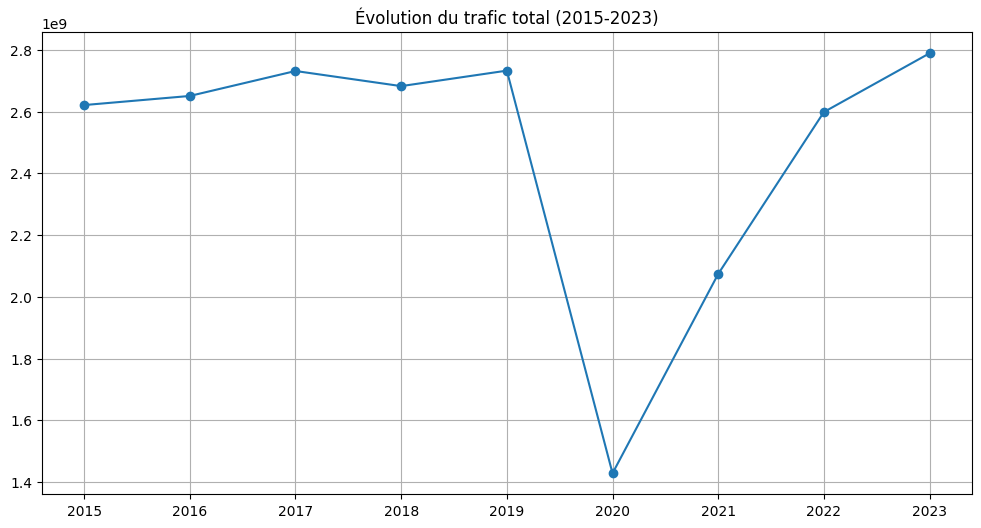

In [69]:
# Évolution du trafic total
yearly_total = pd.DataFrame({
    'année': range(2015, 2024),
    'total_voyageurs': [df_clean[f'total_voyageurs_{year}'].sum() for year in range(2015, 2024)]
})

plt.figure(figsize=(12, 6))
plt.plot(yearly_total['année'], yearly_total['total_voyageurs'], marker='o')
plt.title('Évolution du trafic total (2015-2023)')
plt.grid(True)
plt.show()

<a id='6'></a>
## 6. Préparation pour le clustering

In [70]:
# Sélection des colonnes pour le clustering
cols_cluster = [col for col in df_clean.columns if 'total_voyageurs_20' in col]

# Calcul des variations
df_clean['var_2015_2023'] = (
    (df_clean['total_voyageurs_2023'] - df_clean['total_voyageurs_2015']) 
    / df_clean['total_voyageurs_2015'] * 100
)

df_clean['impact_covid'] = (
    (df_clean['total_voyageurs_2020'] - df_clean['total_voyageurs_2019'])
    / df_clean['total_voyageurs_2019'] * 100
)

<a id='7'></a>
## 7. Export des données nettoyées

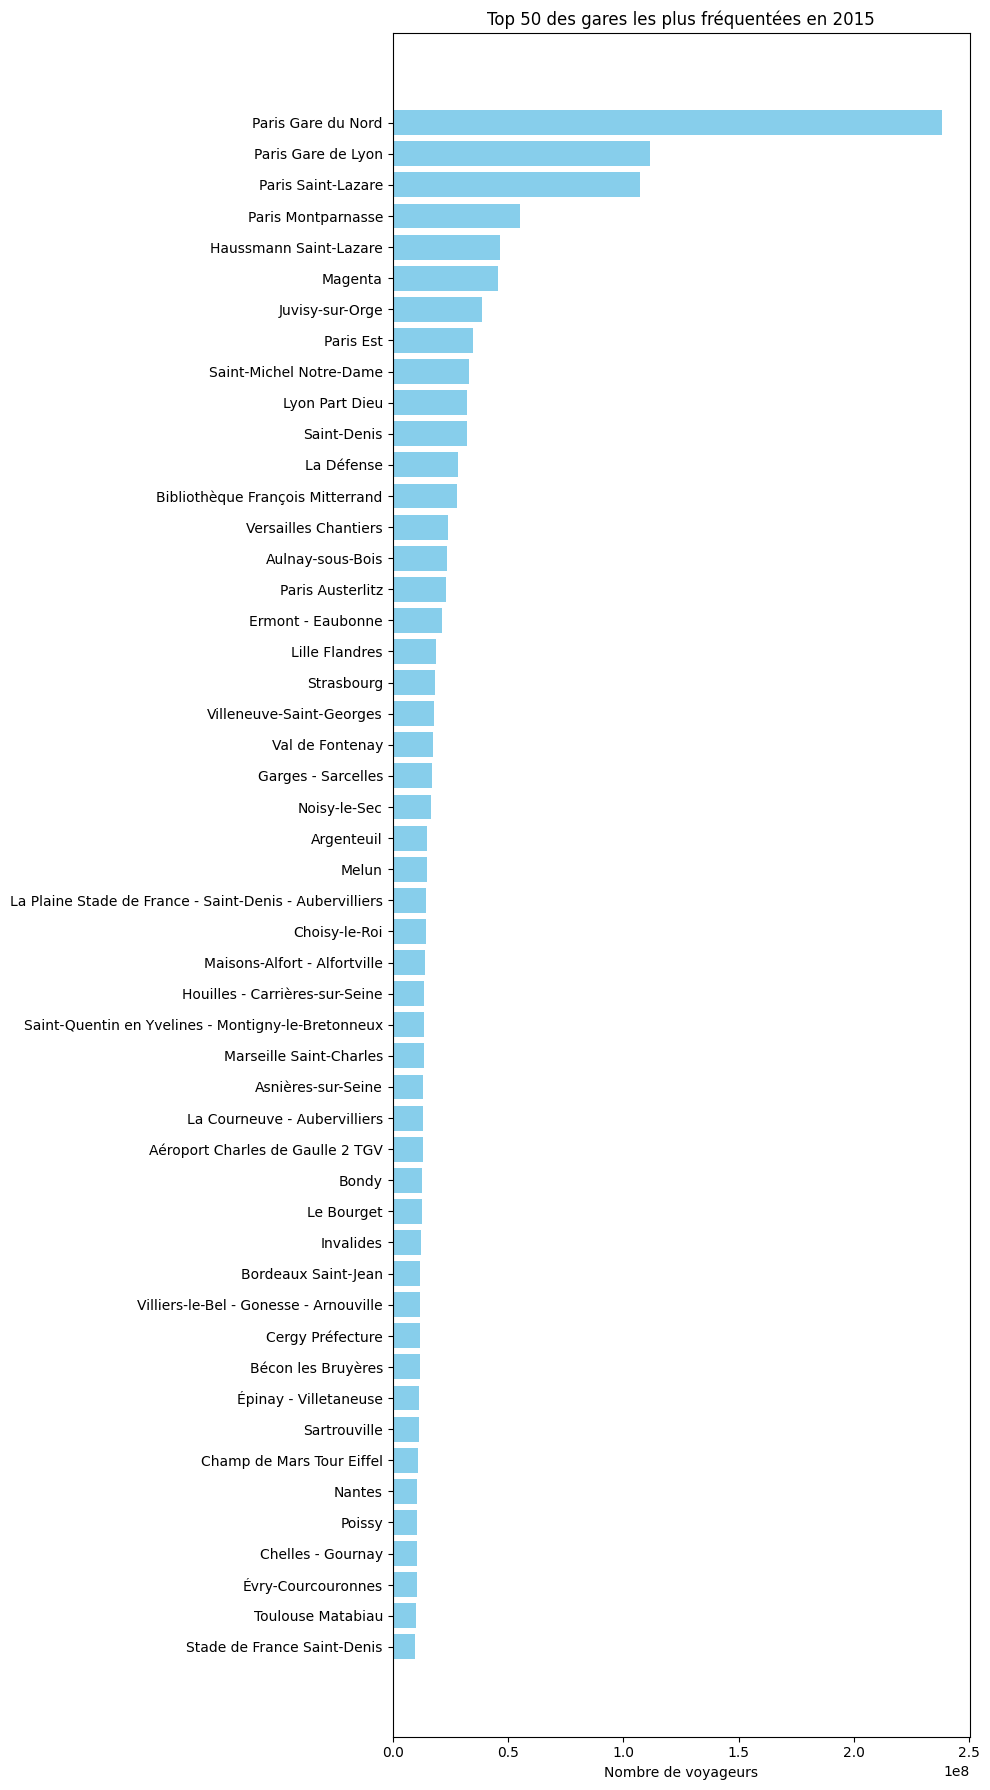

In [71]:
# Top 50 des gares les plus fréquentées 2015
col = "Total Voyageurs 2015"
if col not in df.columns:
    raise ValueError(f"La colonne '{col}' n'existe pas dans le fichier.")

top_50 = df.sort_values(by=col, ascending=False).head(50)

plt.figure(figsize=(10, 18))
plt.barh(top_50["Nom de la gare"], top_50[col], color='skyblue')
plt.xlabel("Nombre de voyageurs")
plt.title("Top 50 des gares les plus fréquentées en 2015")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()